In [27]:
from multi_task_model import Multi_Model
from transformers import InputExample
from transformers import (WEIGHTS_NAME, BertConfig, BertModel, BertTokenizer,
                          RobertaConfig,RobertaModel,RobertaTokenizer,
                          XLNetConfig,XLNetModel,XLNetTokenizer)
from torch.utils.data import TensorDataset
import argparse

parser = argparse.ArgumentParser()
args=parser.parse_known_args()[0]
args.model_type="bert"
args.config_name="./bert-base-uncased/bert-base-uncased-config.json"
args.tokenizer_name="./bert-base-uncased/bert-base-uncased-vocab.txt"
args.model_name_or_path="./bert-base-uncased/bert-base-uncased-pytorch_model.bin"
args.all_task=True
args.aggression_attack_task=False
args.aggression_toxicity_task=False
args.attack_toxicity_task=False

config=BertConfig.from_pretrained(args.config_name ,num_labels=2,finetuning_task="multi_task")
tokenizer = BertTokenizer.from_pretrained(args.tokenizer_name)


In [ ]:
'''
text_a="i have a dick, its bigger than yours! hahaha"
aggression=True
attack=True
toxicity=True

text_b="Make that four, fifth is underway.  This is rediculous!   "
aggression=True
attack=False
toxicity=True

text_c="Indian people say this is just British hogwash."
aggression=True
attack=False
toxicity=False

text_d="Don't spam Wikipedia. I will block you if you add that stuff to Hentai again."
aggression=True
attack=False
toxicity=False

text_e="If you continue to vandalize MY TALK PAGE you will be blocked from living on the Earth. WAM! Thank you  "
aggression=False
attack=True
toxicity=False

text_m="NEWLINE_TOKENNEWLINE_TOKEN== Pig Fenian ==NEWLINE_TOKENNEWLINE_TOKENNice wrist action boys, keep it up."
aggression=False
attack=False
toxicity=True
'''

In [123]:
from utils import convert_examples_to_features
import torch
from torch.utils.data import DataLoader

tokenizer = BertTokenizer.from_pretrained(args.tokenizer_name)
example=[]
text="for dipshits especially the guy who changed my comment"
text = text.replace("NEWLINE_TOKEN", "")
text = text.replace("TAB_TOKEN", "")
label=['1','1','1']
example.append(InputExample(guid="train-0", text_a=text, text_b=None, label=label))
label_list=["0","1"]
features = convert_examples_to_features(example, tokenizer, label_list=label_list,
                                                max_length=128, output_mode="classification",
                                                pad_on_left=False,
                                                # pad on the left for xlnet
                                                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                pad_token_segment_id= 0, )

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)

aggression_all_label=torch.tensor([f.aggression_label for f in features], dtype=torch.long)
attack_all_label_label=torch.tensor([f.attack_label for f in features], dtype=torch.long)
toxicity_all_label=torch.tensor([f.toxicity_label for f in features], dtype=torch.long)


dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, aggression_all_label,attack_all_label_label,toxicity_all_label)
print(dataset)

In [124]:
from multi_task_model import Multi_Model
import numpy as np
from utils import get_char_vocab,char2ids
model=Multi_Model(args,config)
args.device = torch.device("cpu")

checkpoint='./check_points/checkpoint-5950/model.pt'
prefix = checkpoint.split('/')[-1] if checkpoint.find('checkpoint') != -1 else ""
model.load_state_dict(torch.load(checkpoint))

aggression_tensor = torch.tensor(tokenizer.encode("aggression"), dtype=torch.long).to(args.device)
attack_tensor = torch.tensor(tokenizer.encode("attack"), dtype=torch.long).to(args.device)
toxicity_tensor = torch.tensor(tokenizer.encode("toxicity"), dtype=torch.long).to(args.device)

char_vocab = get_char_vocab()
aggression_char_ids = char2ids("aggression", char_vocab)
attack_char_ids = char2ids("attack", char_vocab)
toxicity_char_ids = char2ids("toxicity", char_vocab)

aggression_char_tenor = torch.tensor(aggression_char_ids, dtype=torch.long).to(args.device)
attack_char_tenor = torch.tensor(attack_char_ids, dtype=torch.long).to(args.device)
toxicity_char_tenor = torch.tensor(toxicity_char_ids, dtype=torch.long).to(args.device)

dataloader = DataLoader(dataset,batch_size=1)

model.to(args.device)
for batch in dataloader:
    model.eval()
    batch = tuple(t.to(args.device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1],'token_type_ids':batch[2], 
                  'aggression_labels': batch[3],'attack_labels': batch[4],
                  'toxicity_labels': batch[5],'aggression_tensor': aggression_tensor, 
                  'attack_tensor': attack_tensor,'toxicity_tensor': toxicity_tensor, 
                  'aggression_char_tensor': aggression_char_tenor,
                  'attack_char_tensor': attack_char_tenor, 'toxicity_char_tensor': toxicity_char_tenor}
        aggression_logits, attack_logits, toxicity_logits, tmp_eval_loss,aggression_atten,attack_atten,toxicity_atten=model(**inputs)
        aggression_weight=aggression_atten.squeeze(0)
        attack_weight=attack_atten.squeeze(0)
        toxicity_weight=toxicity_atten.squeeze(0)
        
        print(aggression_weight.shape)
    
    aggression_preds = aggression_logits.detach().cpu().numpy()
    aggression_out_label_ids = inputs['aggression_labels'].detach().cpu().numpy()
    
    attack_preds = attack_logits.detach().cpu().numpy()
    attack_out_label_ids = inputs['attack_labels'].detach().cpu().numpy()

    toxicity_preds = toxicity_logits.detach().cpu().numpy()
    toxicity_out_label_ids = inputs['toxicity_labels'].detach().cpu().numpy()
    
aggression_preds = np.argmax(aggression_preds, axis=1)
attack_preds = np.argmax(attack_preds, axis=1)
toxicity_preds = np.argmax(toxicity_preds, axis=1)
print(aggression_preds)
print(attack_preds)
print(toxicity_preds)

torch.Size([128, 1])
[0]
[0]
[0]


In [125]:
text="for dipshits especially the guy who changed my comment"
text = text.replace("NEWLINE_TOKEN", "")
text = text.replace("TAB_TOKEN", "")
print(tokenizer.tokenize(text))
inputs = tokenizer.encode_plus(
            text,
           None,
            add_special_tokens=True,
            max_length=128,
        )
print(inputs["input_ids"])


['for', 'dip', '##shi', '##ts', 'especially', 'the', 'guy', 'who', 'changed', 'my', 'comment']
[101, 2005, 16510, 6182, 3215, 2926, 1996, 3124, 2040, 2904, 2026, 7615, 102]


In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

attentions=attack_weight.numpy()
attentions=attentions[1:len(tokenizer.tokenize(text))+1]



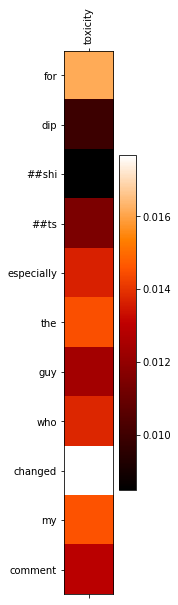

In [141]:
import matplotlib.ticker as ticker
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with color bar
    fig = plt.figure(figsize=(2,10))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions)
    #cax = ax.matshow(attentions, cmap='autumn')
    cax = ax.matshow(attentions, cmap='gist_heat')
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels(['']+output_words, rotation=90)
    text=tokenizer.tokenize("for dipshits especially the guy who changed my comment")

    ax.set_yticklabels(['']+text)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def evaluateAndShowAttention(input_sentence):
    showAttention(input_sentence, ["toxicity"], attentions)
evaluateAndShowAttention(text)